# Import Libraries

In [73]:
from get_files_dynamic import get_super_table
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import time

# Goal of Phase 1 

There is a slight change of plans. Instead of breaking up phases 1 and 3, I will do them together.   
So the goal is to make a few models. See how long they take to process the data / train the model and make predictions.  
For all cases we will tune the model to its best accuracy possible - using as much varaibles as possible   
Then after that we will train XX models - one for each camera  
To test the speed, we will do   
1. single query one model 
2. multiple query one model 
3. single query multiple camera 
4. multiple query multiple camera 

This will be done for the single model as well as the multiple model  
That way we can see the time taken for each  

The difference between single and multiple query can be like single is one by one input into the model.  
Multiple can be pass in all at one go 

For the first attempt, i gonna focus on the decision tree since it is the fastest to train so far and is giving good accuracy. Then from there we'll see how to extend to the rest 

# Get Dataset 

In [15]:
df = get_super_table()

In [16]:
df.head()

,call_timestamp,cam_id,non_rainfall_station_id,rainfall_station_id,2hr_forecast_area,compass,direction,rainfall_realtime,wind_speed_realtime,wind_dir_realtime,...,24hr_period_1_start,24hr_period_1_end,24hr_period_1,24hr_period_2_start,24hr_period_2_end,24hr_period_2,24hr_period_3_start,24hr_period_3_end,24hr_period_3,trafficCongestion
0,2022-04-10T034724,1001,S107,S119,Kallang,south,1,0.0,1.2,325.0,...,2022-04-10T000000,2022-04-10T060000,Partly Cloudy (Night),2022-04-10T060000,2022-04-10T120000,Partly Cloudy (Day),2022-04-10T120000,2022-04-10T180000,Thundery Showers,None
1,2022-04-10T034724,1001,S107,S119,Kallang,south,2,0.0,1.2,325.0,...,2022-04-10T000000,2022-04-10T060000,Partly Cloudy (Night),2022-04-10T060000,2022-04-10T120000,Partly Cloudy (Day),2022-04-10T120000,2022-04-10T180000,Thundery Showers,None
2,2022-04-10T034724,1501,S107,S108,City,south,1,0.0,1.2,325.0,...,2022-04-10T000000,2022-04-10T060000,Partly Cloudy (Night),2022-04-10T060000,2022-04-10T120000,Partly Cloudy (Day),2022-04-10T120000,2022-04-10T180000,Thundery Showers,None
3,2022-04-10T034724,1502,S107,S108,City,south,1,0.0,1.2,325.0,...,2022-04-10T000000,2022-04-10T060000,Partly Cloudy (Night),2022-04-10T060000,2022-04-10T120000,Partly Cloudy (Day),2022-04-10T120000,2022-04-10T180000,Thundery Showers,None
4,2022-04-10T034724,1503,S107,S108,City,south,1,0.0,1.2,325.0,...,2022-04-10T000000,2022-04-10T060000,Partly Cloudy (Night),2022-04-10T060000,2022-04-10T120000,Partly Cloudy (Day),2022-04-10T120000,2022-04-10T180000,Thundery Showers,Medium


# Some transformations needed for all 

Note that i still kept the station/area identifiers.  
Should probably drop them but i think will drop later manually when needed 

In [17]:
# May just end up dropping since too much effort to convert and very little values 
df.call_timestamp = pd.to_datetime(df.call_timestamp)
df["24hr_start"] = pd.to_datetime(df["24hr_start"])
df["24hr_end"] = pd.to_datetime(df["24hr_end"])
df["24hr_period_1_start"] = pd.to_datetime(df["24hr_period_1_start"])
df["24hr_period_1_end"] = pd.to_datetime(df["24hr_period_1_end"])
df["24hr_period_2_start"] = pd.to_datetime(df["24hr_period_2_start"])
df["24hr_period_2_end"] = pd.to_datetime(df["24hr_period_2_end"])
df["24hr_period_3_start"] = pd.to_datetime(df["24hr_period_3_start"])
df["24hr_period_3_end"] = pd.to_datetime(df["24hr_period_3_end"])

# Make dummy values
dummy_df = pd.get_dummies(df.drop(["trafficCongestion", "rainfall_station_id", "non_rainfall_station_id",
                                 "2hr_forecast_area", "compass"], axis = 1))
df_keep = df[["trafficCongestion", "rainfall_station_id", "non_rainfall_station_id", "2hr_forecast_area", "compass"]]

# reform with dropped values 
dummy_df = pd.merge(dummy_df, df_keep, left_index=True, right_index=True)

In [21]:
numeric_df = df[["rainfall_realtime", "wind_speed_realtime", "wind_dir_realtime", 'humidity_realtime', 'air_temp_realtime', 
           '4day_temperature_low_1', '4day_temperature_low_2', '4day_temperature_low_3', '4day_temperature_low_4',
           '4day_temperature_high_1', '4day_temperature_high_2', '4day_temperature_high_3', '4day_temperature_high_4',
           '4day_relative_humidity_low_1', '4day_relative_humidity_low_2','4day_relative_humidity_low_3',
           '4day_relative_humidity_low_4', '4day_relative_humidity_high_1', '4day_relative_humidity_high_2',
           '4day_relative_humidity_high_3', '4day_relative_humidity_high_4','4day_wind_speed_low_1',
           '4day_wind_speed_low_2', '4day_wind_speed_low_3', '4day_wind_speed_low_4','4day_wind_speed_high_1',
           '4day_wind_speed_high_2','4day_wind_speed_high_3', '4day_wind_speed_high_4', 
           '24hr_general_relative_humidity_low','24hr_general_relative_humidity_high', '24hr_general_temperature_low',
           '24hr_general_temperature_high', '24hr_general_wind_speed_low', '24hr_general_wind_speed_high', 
           "trafficCongestion", 
          "cam_id", "direction", "rainfall_station_id", "non_rainfall_station_id", "2hr_forecast_area", "compass"]]

In [29]:
drop_identifiers = ["rainfall_station_id", "non_rainfall_station_id", "2hr_forecast_area", "compass"]
drop_camera = ["cam_id", "direction"]
drop_time = ["call_timestamp", "24hr_start", "24hr_end", "24hr_period_1_start", "24hr_period_1_end",
            "24hr_period_2_start", "24hr_period_2_end", "24hr_period_3_start", "24hr_period_3_end"]

# Helpers 

In [18]:
def plot_confusion(predicted, actual):
    cm = confusion_matrix(actual, predicted)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot(colorbar= False, cmap = "binary")
    
def get_confusion(predicted, actual):
    cm = confusion_matrix(actual, predicted)
    return pd.DataFrame(cm)

def get_accuracy(predicted, actual):
    return np.mean(predicted == actual)

# Decision Tree

For the first single tree will use the numeric without the identifiers 
By right need validation step for the tuning process but will skip for now since it is just a prototype

But apparently the camera id damn good for predicting. 
Time doesnt work for the decision tree model - if want to use will need more pre-processing 

## Single Model, Dummy 

In [96]:
df = dummy_df.drop(drop_identifiers, axis = 1)
#df = df.drop(drop_camera, axis = 1)
df = df.drop(drop_time, axis = 1)
df = df.dropna()

X = df.drop("trafficCongestion", axis = 1)
Y = df.trafficCongestion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [97]:
start_time = time.perf_counter()
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

Time to train decision tree is 1.1902


In [84]:
#plot_confusion(y_test, clf.predict(X_test))

In [105]:
# Single Query 
acc = []
start_time = time.perf_counter()
for i in range(len(X_test)):
    accuracy = get_accuracy(y_test[i], clf.predict(X_test.iloc[i:i+1,:]))
    acc.append(accuracy)
end_time = time.perf_counter()
print(f"The accuracy is: {np.mean(acc)}")
print(f"The time taken to predict is {end_time - start_time:0.4f} seconds")

The accuracy is: 0.8551817144437913
The time taken to predict is 30.0284 seconds


In [106]:
# Multiple Query 
start_time = time.perf_counter()
accuracy = get_accuracy(y_test, clf.predict(X_test))
end_time = time.perf_counter()
print(f"The accuracy is: {accuracy}")
print(f"The time taken to predict is {end_time - start_time:0.4f} seconds")

The accuracy is: 0.8551817144437913
The time taken to predict is 0.0264 seconds


## Single Model, Numeric 

In [107]:
df = numeric_df.drop(drop_identifiers, axis = 1)
df = df.drop(drop_camera, axis = 1)
#df = df.drop(drop_time, axis = 1)
df = df.dropna()

X = df.drop("trafficCongestion", axis = 1)
Y = df.trafficCongestion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [108]:
start_time = time.perf_counter()
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

Time to train decision tree is 0.2732


In [109]:
#plot_confusion(y_test, clf.predict(X_test))

In [112]:
# Single Query 
acc = []
start_time = time.perf_counter()
for i in range(len(X_test)):
    accuracy = get_accuracy(y_test[i], clf.predict(X_test.iloc[i:i+1,:]))
    acc.append(accuracy)
end_time = time.perf_counter()
print(f"The accuracy is: {np.mean(acc)}")
print(f"The time taken to predict is {end_time - start_time:0.4f} seconds")

The accuracy is: 0.5853591064697949
The time taken to predict is 24.1547 seconds


In [111]:
# Mutliple Query 
start_time = time.perf_counter()
accuracy = get_accuracy(y_test, clf.predict(X_test))
end_time = time.perf_counter()
print(f"The accuracy is: {accuracy}")
print(f"The time taken to predict is {end_time - start_time:0.4f} seconds")

The accuracy is: 0.5853591064697949
The time taken to predict is 0.0126 seconds


# Multiple Models, dummy 

In [121]:
df = dummy_df.drop(drop_identifiers, axis = 1)
#df = df.drop(drop_camera, axis = 1)
df = df.drop(drop_time, axis = 1)
df = df.dropna()

X = df.drop("trafficCongestion", axis = 1)
Y = df.trafficCongestion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

all_camera = dummy_df.cam_id.unique()
all_models = {}

start_time = time.perf_counter()
for cam in all_camera:
    index = X_train.cam_id == cam
    train_x = X_train[index]
    train_y = y_train[index]
    
    clf = DecisionTreeClassifier(random_state=0).fit(train_x, train_y)
    
    all_models[cam] = clf

end_time = time.perf_counter()
print(f"Time to train all the decision trees are {end_time - start_time:0.4f}")

Time to train all the decision trees are 0.6916


In [122]:
# Sinle Query 
start_time = time.perf_counter()
acc = []
for cam in all_camera:
    index = X_test.cam_id == cam
    for i in range(sum(index)):
        accuracy = get_accuracy(y_test[index][i], all_models[cam].predict(X_test[index].iloc[i:i+1,:]))
        acc.append(accuracy)
end_time = time.perf_counter()
print(f"The average accuracy is: {np.mean(acc)}")
print(f"The total time taken to predict is {end_time - start_time:0.4f} seconds")

The average accuracy is: 0.8551125557591894
The total time taken to predict is 46.1182 seconds


In [123]:
# Multiple Query 
start_time = time.perf_counter()
acc = []
for cam in all_camera:
    index = X_test.cam_id == cam
    accuracy = get_accuracy(y_test[index], all_models[cam].predict(X_test[index]))
    acc.append(accuracy)
end_time = time.perf_counter()
print(f"The average accuracy is: {np.mean(acc)}")
print(f"The total time taken to predict is {end_time - start_time:0.4f} seconds")

The average accuracy is: 0.8554581816540641
The total time taken to predict is 0.1569 seconds


# Multiple Models Numeric

In [124]:
df = numeric_df.drop(drop_identifiers, axis = 1)
#df = df.drop(drop_camera, axis = 1)
#df = df.drop(drop_time, axis = 1)
df = df.dropna()

X = df.drop("trafficCongestion", axis = 1)
Y = df.trafficCongestion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

all_camera = dummy_df.cam_id.unique()
all_models = {}

start_time = time.perf_counter()
for cam in all_camera:
    index = X_train.cam_id == cam
    train_x = X_train[index]
    train_y = y_train[index]
    
    clf = DecisionTreeClassifier(random_state=0).fit(train_x, train_y)
    
    all_models[cam] = clf

end_time = time.perf_counter()
print(f"Time to train all the decision trees are {end_time - start_time:0.4f}")

Time to train all the decision trees are 0.5419


In [125]:
# Single Query 
start_time = time.perf_counter()
acc = []
for cam in all_camera:
    index = X_test.cam_id == cam
    for i in range(sum(index)):
        accuracy = get_accuracy(y_test[index][i], all_models[cam].predict(X_test[index].iloc[i:i+1,:]))
        acc.append(accuracy)
end_time = time.perf_counter()
print(f"The average accuracy is: {np.mean(acc)}")
print(f"The total time taken to predict is {end_time - start_time:0.4f} seconds")

The average accuracy is: 0.8498910750717521
The total time taken to predict is 33.5791 seconds


In [126]:
# Multiple Query 
start_time = time.perf_counter()
acc = []
for cam in all_camera:
    index = X_test.cam_id == cam
    accuracy = get_accuracy(y_test[index], all_models[cam].predict(X_test[index]))
    acc.append(accuracy)
end_time = time.perf_counter()
print(f"The average accuracy is: {np.mean(acc)}")
print(f"The total time taken to predict is {end_time - start_time:0.4f} seconds")

The average accuracy is: 0.8495409168841885
The total time taken to predict is 0.1183 seconds


# The rest below can ignore 

# Model Attempt 1 
For ease of modelling, i will only deal with a logisitic linear model consisiting only of the numerical variables. For ease of modelling, any rows with NA will be dropped. No distingushing factor of the stations will alos be considered 

In [9]:
X = data.drop("trafficCongestion", axis = 1)
Y = data.trafficCongestion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [26]:
start_time = time.perf_counter()
clf = LogisticRegression(random_state=0, max_iter = 10000).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train Logsitic Regression is {end_time - start_time:0.4f} seconds")

Time to train Logsitic Regression is 144.6573


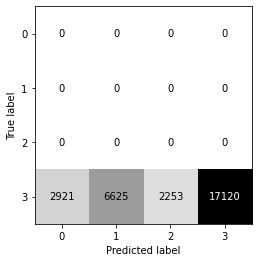

In [12]:
plot_confusion(y_test, clf.predict(X_test))

In [27]:
start_time = time.perf_counter()
accuracy = get_accuracy(y_test, clf.predict(X_test))
end_time = time.perf_counter()
print(f"The accuracy is: {accuracy}")
print(f"The time taken to predict is {end_time - start_time:0.4f} seconds")

The accuracy is: 0.5919983401915696
The time taken to predict is 0.0124 seconds


# Decision Tree

So "fresh start" and ignore the rest.   

In [40]:
X = df.drop("trafficCongestion", axis = 1)
Y = df.trafficCongestion.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [41]:
start_time = time.perf_counter()
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

TypeError: The DType <class 'numpy.dtype[int64]'> could not be promoted by <class 'numpy.dtype[datetime64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[object_]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[object_]'>)

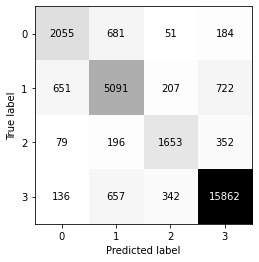

In [14]:
plot_confusion(y_test, clf.predict(X_test))

In [16]:
get_accuracy(y_test, clf.predict(X_test))

0.8527611604827277

In [17]:
plot_tree(clf);

Error in callback <function flush_figures at 0x000002B6535FD4C0> (for post_execute):


KeyboardInterrupt: 

# K NN 

In [18]:
clf = KNeighborsClassifier().fit(X_train, y_train)

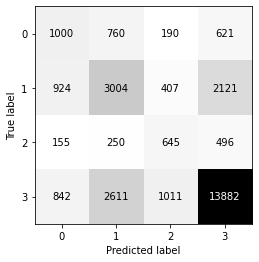

In [19]:
plot_confusion(y_test, clf.predict(X_test))

In [20]:
get_accuracy(y_test, clf.predict(X_test))

0.6407897921781528

# MLP 
This is a fast way to get a neural net modelling 
Need more data

In [21]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2,4,16,32,16,4,2), random_state=1).fit(X_train, y_train)

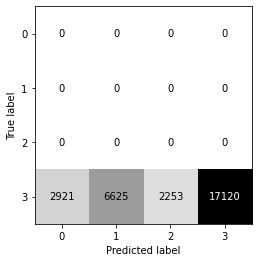

In [22]:
plot_confusion(y_test, clf.predict(X_test))

In [23]:
get_accuracy(y_test, clf.predict(X_test))

0.5919983401915696